In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from datetime import timedelta

# visualization
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

%matplotlib inline

# configure visualizations
sns.set_style('whitegrid')
figsize=(8,6)

In [2]:
def load_df(path, cols, use_threads=True):
    try:
        return pq.read_table(path, columns=cols, use_threads=use_threads).to_pandas()
    except Exception as e:
        print(e)

def downcast_ints(df):
    # downcast int types
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    df[converted_int.columns] = converted_int
    
    return df
        
def prepare(path,cols,dtypes):

    df = load_df(path,cols)
    df = df.astype(dtypes)
    df = df.reset_index(drop=True)
    df = downcast_ints(df)
    
    return df

In [3]:
def pieOthers(dfVars,dfVals,threshold):
    df = pd.DataFrame(
        data = {'var': dfVars, 'value' : dfVals},
        ).sort_values('value', ascending = False)
    
    if threshold > 0 :
        df2 = df[:threshold].copy()
        new_row = pd.DataFrame(data = {
            'var' : ['Others'],
            'value' : [dfVals[threshold:].sum()]
        })

        df2 = pd.concat([df2, new_row])
    else:
        df2 = df
        
    percent = 100.*df2['value']/df2['value'].sum()
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(df2['var'], percent)]
    #labels = ['{0} - {1}'.format(i,j) for i,j in zip(df2['var'], df2['value'])]
    
    colorsX = plt.cm.tab20.colors
    patches, texts = plt.pie(df2['value'], shadow=True, startangle=90, colors = colorsX)
    plt.legend(patches, labels, loc="best")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
def pieOthers2(dfVars,dfVals,threshold):
    df = pd.DataFrame(
        data = {'var': dfVars, 'value' : dfVals},
        ).sort_values('value', ascending = False)
    
    if threshold > 0 :
        df2 = df[:threshold].copy()
        new_row = pd.DataFrame(data = {
            'var' : ['Others'],
            'value' : [dfVals[threshold:].sum()]
        })

        df2 = pd.concat([df2, new_row])
    else:
        df2 = df
    
    percent = 100.*df2['value']/df2['value'].sum()
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(df2['var'], percent)]
    
    #labels = ['{0} - {1}'.format(i,j) for i,j in zip(df2['var'], df2['value'])]
    
    fig=plt.figure(figsize=(7,5))
    gs1 = gridspec.GridSpec(1,1,
        left=0.1,right=0.7,
        bottom=0.1,top=0.7,
    )
    pie_ax=fig.add_subplot(gs1[0])
    
    colors = plt.cm.tab20.colors
    wedges, texts = pie_ax.pie(
        df2['value'],
        shadow=True,
        colors=colors,
        startangle=90,
    )
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle,"color":colors[i]})
        pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                     horizontalalignment=horizontalalignment, **kw)
    pie_ax.axis('equal')

    plt.show()

In [4]:
cols = ['sample_id', 'name', 'sub', 'label']
dtypes = {'sample_id' : 'uint32', 'name' : 'category', 'sub' : 'category', 'label' : 'category'}
df = prepare('2-datasets/top15Apps.parquet',cols,dtypes)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159935697 entries, 0 to 159935696
Data columns (total 4 columns):
sample_id    uint32
name         category
sub          category
label        category
dtypes: category(3), uint32(1)
memory usage: 1.0 GB


In [6]:
df.head(100)

,sample_id,name,sub,label
0,1,com.google.android.music,main,google play music
1,1,com.facebook.katana,videoplayer,facebook
2,1,com.facebook.orca,videoplayer,messenger
3,1,com.facebook.katana,core_app,facebook
4,1,com.facebook.orca,core_app,messenger
...,...,...,...,...
95,12,com.google.android.googlequicksearchbox,interactor,google
96,13,com.google.android.music,main,google play music
97,13,com.facebook.katana,videoplayer,facebook
98,13,com.facebook.orca,videoplayer,messenger


In [7]:
dfLabelGB = df.groupby(['label'])['label'].count().reset_index(name='count').sort_values(['count'], ascending=False)
dfFacebook = df.loc[df['label'] == "facebook"].groupby(['sub'])['sub'].count().reset_index(name='count').sort_values(['count'], ascending=False)
dfMessenger = df.loc[df['label'] == "messenger"].groupby(['sub'])['sub'].count().reset_index(name='count').sort_values(['count'], ascending=False)
dfInstagram = df.loc[df['label'] == "instagram"].groupby(['sub'])['sub'].count().reset_index(name='count').sort_values(['count'], ascending=False)


In [9]:
print("Apps:"+str(len(df.index)))
print(dfLabelGB['count'].sum())
print(dfFacebook['count'].sum())
print(dfMessenger['count'].sum())
print(dfInstagram['count'].sum())

Apps:159935697
159935697
19942031
17912689
12354857


                label     count
5              google  35779354
2            facebook  19942031
10          messenger  17912689
6   google play music  14976191
0              chrome  13241911
8           instagram  12354857
11            shareit   9198883
3             fb lite   7475948
13           whatsapp   6236659
12            vidmate   5974782
4              gboard   5844791
14            youtube   4785253
7            hangouts   3076154
1    es file explorer   1980167
9                maps   1156027


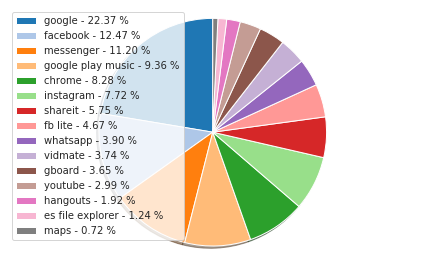

In [39]:
print(dfLabelGB)
pieOthers(dfLabelGB['label'],dfLabelGB['count'],0)

                    sub    count
5              core_app  9694894
87          videoplayer  5280933
28         notification  4901672
29               optsvc    46496
3               browser    12769
..                  ...      ...
35  privileged_process4        0
34  privileged_process3        0
33  privileged_process2        0
32  privileged_process1        0
89      webview_service        0

[90 rows x 2 columns]


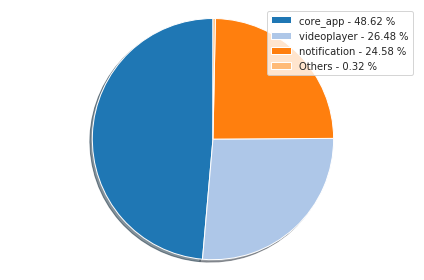

In [40]:
print(dfFacebook)
pieOthers(dfFacebook['sub'],dfFacebook['count'],3)

                       sub     count
5                 core_app  10987445
87             videoplayer   6797841
28            notification    117310
13             fwkstartlog      5449
29                  optsvc      3748
..                     ...       ...
33     privileged_process2         0
32     privileged_process1         0
31     privileged_process0         0
27  networklocationservice         0
89         webview_service         0

[90 rows x 2 columns]


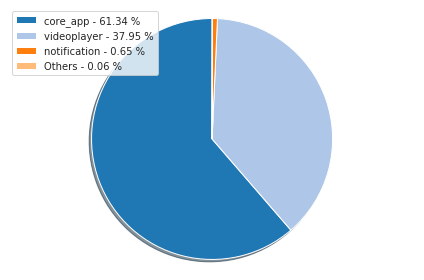

In [41]:
print(dfMessenger)
pieOthers(dfMessenger['sub'],dfMessenger['count'],3)

                    sub    count
26                 mqtt  7126268
87          videoplayer  3086168
5              core_app  1690192
15             igplayer   447368
3               browser     3871
..                  ...      ...
32  privileged_process1        0
31  privileged_process0        0
29               optsvc        0
28         notification        0
89      webview_service        0

[90 rows x 2 columns]


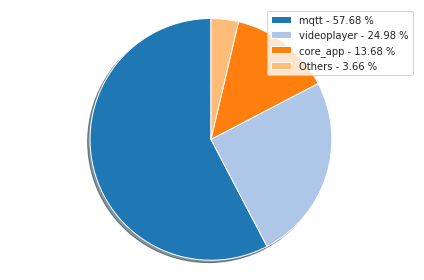

In [42]:
print(dfInstagram)
pieOthers(dfInstagram['sub'],dfInstagram['count'],3)